# 🧪 Synthetic CT Oncology Cohort

Generates multi-visit patient timelines, writes TXT reports and JSON sidecars, and exports a RECIST-style JSONL.

## 0) Imports

In [1]:
# Add synthrad module directory to path
from pathlib import Path
import sys
import shutil
import json

MODULE_DIR = Path("/Users/eri/synthetic_reports/src/synthrad")
assert (MODULE_DIR / "generator.py").exists(), f"Can't find generator.py in {MODULE_DIR}"
sys.path.insert(0, str(MODULE_DIR))

# Import and reload modules
from synthrad import generator as gen, lexicons, schema
import importlib
importlib.reload(gen)
importlib.reload(lexicons) 
importlib.reload(schema)

print("Loaded modules from:", MODULE_DIR)

Loaded modules from: /Users/eri/synthetic_reports/src/synthrad


## 1) Cohort Parameters

In [2]:
# ---- cohort knobs ----
N_PATIENTS            = 8          # number of patients to synthesize
SEED                  = 42         # deterministic
STUDIES_PER_PATIENT   = 5          # max studies per patient (2–10 per your code)
FORCE_LOBE            = None       # choose from: None, "RUL","RML","RLL","LUL","LLL"

# Stage distribution (I/II/III/IV) — will be normalized by your parser
STAGE_DIST_STR        = "I:0.25,II:0.25,III:0.30,IV:0.20"

# Response distribution for follow-ups — normalized internally
RESPONSE_DIST_STR     = "CR:0.1,PR:0.3,SD:0.4,PD:0.2"

# Output directory (feel free to change)
OUT_DIR               = Path("./out_synthrad")
if OUT_DIR.exists():
    print("Cleaning existing output dir…")
    shutil.rmtree(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Config OK")

Cleaning existing output dir…
Config OK


## 2) Generate the Cohort (multi-visit timelines)

In [3]:
rng = gen.random.Random(SEED)
stage_dist     = gen.parse_stage_dist(STAGE_DIST_STR)
response_dist  = gen.parse_response_dist(RESPONSE_DIST_STR)

all_cases = []
all_dates = []

for i in range(N_PATIENTS):
    patient_id = f"P{i:04d}"
    try:
        cases, study_dates = gen.generate_patient_timeline(
            patient_id=patient_id,
            seed=rng.randint(0, 10_000_000),
            stage_dist=stage_dist,
            lobe=FORCE_LOBE,
            max_studies=STUDIES_PER_PATIENT,
            response_dist=response_dist
        )
        # Write each study (TXT report + JSON sidecar + anatomic mapping)
        for c in cases:
            gen.write_case(c, str(OUT_DIR), c.meta.accession_number, use_radlex=True)
        all_cases.extend(cases)
        all_dates.extend(study_dates)
    except ZeroDivisionError:
        print(f"Warning: Skipping patient {patient_id} due to zero SLD in baseline scan")
        continue

print(f"Created {len(all_cases)} studies across {len(set(c.meta.patient_id for c in all_cases))} patients → {OUT_DIR.resolve()}")

Created 38 studies across 8 patients → /Users/eri/synthetic_reports/notebooks/out_synthrad


## 3) Peek at the Folder Structure

In [4]:
def tree(path: Path, depth=3, prefix=""):
    if depth < 0: 
        return
    files = sorted(path.iterdir(), key=lambda p:(p.is_file(), p.name))
    for p in files:
        print(prefix + ("📄 " if p.is_file() else "📁 ") + p.name)
        if p.is_dir():
            tree(p, depth-1, prefix + "    ")

tree(OUT_DIR, depth=4)

📁 P0000
    📁 study_01
        📄 20201001743186.json
        📄 20201001743186.txt
    📁 study_02
        📄 20200908797803.json
        📄 20200908797803.txt
    📁 study_03
        📄 20251204931410.json
        📄 20251204931410.txt
    📁 study_04
        📄 20250305607114.json
        📄 20250305607114.txt
    📁 study_05
        📄 20220914542280.json
        📄 20220914542280.txt
    📁 study_06
        📄 20220801936752.json
        📄 20220801936752.txt
📁 P0001
    📁 study_01
        📄 20210120999425.json
        📄 20210120999425.txt
    📁 study_02
        📄 20241023981737.json
        📄 20241023981737.txt
    📁 study_03
        📄 20241121340002.json
        📄 20241121340002.txt
📁 P0002
    📁 study_01
        📄 20250522351155.json
        📄 20250522351155.txt
    📁 study_02
        📄 20230218760289.json
        📄 20230218760289.txt
    📁 study_03
        📄 20241201880713.json
        📄 20241201880713.txt
    📁 study_04
        📄 20231016723092.json
        📄 20231016723092.txt
    📁 study_05

## 4) Load & Display a Sample Report + JSON

In [5]:
# grab one patient/study deterministically
some_patient_dir = sorted([p for p in OUT_DIR.iterdir() if p.is_dir()])[0]
some_study_dir   = sorted(some_patient_dir.iterdir())[0]   # study_01
sample_files     = sorted(some_study_dir.glob("*.txt"))
assert sample_files, "No TXT reports found"
sample_txt       = sample_files[0]
sample_json      = sample_txt.with_suffix(".json")

print("TXT:", sample_txt)
print("JSON:", sample_json)

print("\n=== TXT REPORT ===\n")
print(Path(sample_txt).read_text())

print("\n=== JSON (truncated) ===\n")
j = json.loads(Path(sample_json).read_text())
print(json.dumps(j, indent=2)[:2000] + "\n... (truncated) ...")

TXT: out_synthrad/P0000/study_01/20201001743186.txt
JSON: out_synthrad/P0000/study_01/20201001743186.json

=== TXT REPORT ===

TECHNIQUE: CT chest, abdomen, and pelvis with IV contrast. Axial images with multiplanar reconstructions.
COMPARISON: None.

FINDINGS:
Lungs/Primary: There is a 14 mm right middle lobe pulmonary mass with adjacent volume loss. (baseline measurement).
Mediastinum/Lymph nodes:
  left lower paratracheal (4L) lymph node subcentimeter in short axis. (baseline measurement).
  Enlarged station 1R (1R) lymph node measuring 18 mm in short axis. (baseline measurement).
Pleura: No pleural effusion.
Abdomen/Pelvis:
  Liver homogeneous in attenuation without focal mass.
  No focal hepatic lesion.
  Spleen normal in size.
  Adrenal glands without nodules.
Bones: No aggressive osseous lesion.

IMPRESSION:
- Primary right middle lobe pulmonary neoplasm 14 mm with adjacent volume loss; baseline measurement.
- Nodal disease involving stations 1R.
- No definite distant metastases

## 5) Summary Table

In [6]:
import pandas as pd

rows = []
for patient_dir in sorted([p for p in OUT_DIR.iterdir() if p.is_dir()]):
    for study_dir in sorted([p for p in patient_dir.iterdir() if p.is_dir()]):
        for jf in study_dir.glob("*.json"):
            data = json.loads(jf.read_text())
            meta   = data["meta"]
            clin   = data["clinical_data"]
            tnm    = clin["tnm"]
            primary = clin["primary"]
            nodes   = clin["nodes"]
            mets    = clin["mets"]
            rows.append({
                "patient_id": meta["patient_id"],
                "visit": meta["visit_number"],
                "accession": meta["accession_number"],
                "comparison_date": meta.get("comparison_date"),
                "T": tnm["T"], "N": tnm["N"], "M": tnm["M"], "Stage": tnm["stage_group"],
                "primary_lobe": primary["lobe"] if primary else None,
                "primary_mm": primary["size_mm"] if primary else None,
                "num_nodes": len(nodes),
                "num_mets": len(mets),
            })

df = pd.DataFrame(rows).sort_values(["patient_id", "visit"])
df.head(10)

/Users/eri/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,patient_id,visit,accession,comparison_date,T,N,M,Stage,primary_lobe,primary_mm,num_nodes,num_mets
0,P0000,1,20201001743186,None,T1b,N0,M0,I,RML,14.0,2,0
1,P0000,2,20200908797803,2024-07-24,T1b,N0,M0,I,RML,13.0,2,0
2,P0000,3,20251204931410,2024-12-18,T1a,N0,M0,I,RML,6.0,1,0
3,P0000,4,20250305607114,2025-02-20,T1a,N0,M1b,IV,RML,7.0,1,1
4,P0000,5,20220914542280,2025-07-26,T1a,N1,M1b,IV,RML,8.0,3,1
5,P0000,6,20220801936752,2026-01-20,T1a,N1,M1b,IV,RML,8.0,3,1
6,P0001,1,20210120999425,None,T2b,N2,M0,III,RML,67.0,2,0
7,P0001,2,20241023981737,2024-01-28,T3,N2,M0,III,RML,96.0,2,0
8,P0001,3,20241121340002,2024-06-05,T3,N2,M0,III,RML,88.0,2,0
9,P0002,1,20250522351155,None,T1c,N0,M0,I,RLL,25.0,0,0


## 6) Export a Cohort JSONL (RECIST-ish) for Apps

In [10]:
import json

jsonl_records = gen.case_to_recist_jsonl(all_cases, all_dates)
jsonl_path = OUT_DIR / "cohort_labels.jsonl"

# Write compact JSONL
with jsonl_path.open("w", encoding="utf-8") as f:
    for rec in jsonl_records:
        f.write(json.dumps(rec, separators=(",", ":")) + "\n")

print("Wrote JSONL:", jsonl_path.resolve())

# Pretty-print a sample (not whole file, just first N)
print("\nSample contents:")
for rec in jsonl_records[:3]:   # just show first 3
    print(json.dumps(rec, indent=2, sort_keys=True))
    print("---")

Wrote JSONL: /Users/eri/synthetic_reports/notebooks/out_synthrad/cohort_labels.jsonl

Sample contents:
{
  "baseline_sld_mm": 32,
  "current_sld_mm": 32,
  "lesions": [
    {
      "baseline_mm": 18,
      "follow_mm": null,
      "kind": "node",
      "lesion_id": "ln_1R_1",
      "location": null,
      "margin": "smooth",
      "necrosis": false,
      "organ": "lymph_node",
      "rule": "short_axis",
      "size_mm_current": 18,
      "station": "1R",
      "suspicious": true,
      "target": true
    },
    {
      "baseline_mm": 14,
      "follow_mm": null,
      "kind": "primary",
      "lesion_id": "primary_RML",
      "location": "RML",
      "margin": "smooth",
      "necrosis": false,
      "organ": "lung",
      "rule": "longest",
      "size_mm_current": 14,
      "station": null,
      "suspicious": true,
      "target": true
    },
    {
      "baseline_mm": null,
      "follow_mm": null,
      "kind": "node",
      "lesion_id": "ln_4L_0",
      "location": null,
      

## 7) (Optional) Tiny Timeline Plot per Patient
- Top panel: Target lesion trajectories (each line = one lesion). You can see shrinkage or growth over time.
- Middle panel: SLD curve, with vertical shading when the stage group changes (e.g. IV bands when new mets appear).
- Bottom panel: TNM breakdown (T, N, M codes under each timepoint) so you can confirm that stage jumps are driven by nodal/metastatic progression, not just tumor size.

In [26]:
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import pandas as pd, numpy as np

def plot_patient_course(pid, per_patient, jsonl_records, max_legend_items=10):
    """Plot all lesions (targets solid, non-targets dashed), SLD, and TNM over time.
       Stage colors are used ONLY on SLD points. Adds RECIST response labels (CR/PR/SD/PD)."""
    # --- timeline & TNM from cases ---
    tl = sorted(per_patient[pid], key=lambda x: x[0])
    dates_cases = [d for d,_ in tl]
    stages = [c.tnm.stage_group for _,c in tl]
    T = [c.tnm.T for _,c in tl]; N = [c.tnm.N for _,c in tl]; M = [c.tnm.M for _,c in tl]
    stage_at = {d.strftime("%Y-%m-%d"): s for d,s in zip(dates_cases, stages)}

    # --- RECIST JSONL for this patient ---
    recs = sorted([r for r in jsonl_records if r["patient_id"] == pid], key=lambda r: r["study_date"])
    if not recs:
        raise ValueError(f"No JSONL records found for patient {pid}")
    dates = pd.to_datetime([r["study_date"] for r in recs])
    sld   = [r["current_sld_mm"] or r["baseline_sld_mm"] or 0 for r in recs]

    # --- baseline SLD ---
    baseline_sld = recs[0]["baseline_sld_mm"] or recs[0]["current_sld_mm"] or 0

    # --- stage → color (for SLD only) ---
    def stgcol(stage):
        s = (stage or "").upper().strip()
        if s.startswith("IV"):   return "purple"
        if s.startswith("III"):  return "red"
        if s.startswith("II"):   return "orange"
        if s.startswith("I"):    return "green"
        return "gray"
    cols = [stgcol(stage_at.get(r["study_date"])) for r in recs]
    stage_colors = {"I":"green","II":"orange","III":"red","IV":"purple"}

    # ---- collect ALL lesion ids that ever appear ----
    all_ids = sorted({l["lesion_id"] for r in recs for l in r["lesions"]})
    base_targets = {l["lesion_id"] for l in recs[0]["lesions"] if l.get("target")}
    series = {lid:[
        float(next((l["size_mm_current"] for l in r["lesions"] if l["lesion_id"]==lid), np.nan))
        for r in recs
    ] for lid in all_ids}

    # new-lesion flags (ignore baseline)
    seen, new_flags = set(), []
    for i, r in enumerate(recs):
        ids = {l["lesion_id"] for l in r["lesions"]}
        new_flags.append(i > 0 and len(ids - seen) > 0)
        seen |= ids

    # --- helper: assign RECIST response ---
    def recist_response(sld_now, new_lesion, baseline):
        if new_lesion:
            return "PD"
        if sld_now == 0:
            return "CR"
        if baseline and sld_now <= 0.7 * baseline:  # ≥30% decrease
            return "PR"
        if baseline and sld_now >= 1.2 * baseline and (sld_now - baseline) >= 5:  # ≥20% increase
            return "PD"
        return "SD"

    responses = [recist_response(s, nf, baseline_sld) for s, nf in zip(sld, new_flags)]

    # --- plotting ---
    fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(11,7),
                                   gridspec_kw={"height_ratios":[2.2,1.2,0.9]},
                                   sharex=True)

    # 1) all lesions
    for lid, ys in series.items():
        is_target = (lid in base_targets)
        ax1.plot(dates, ys, marker="o", lw=1.8,
                 label=lid + ("" if is_target else " (NT)"),
                 ls="-" if is_target else "--",
                 alpha=1.0 if is_target else 0.85, zorder=2)
    ax1.set_ylabel("Lesion size (mm)")
    ax1.set_title(f"Patient {pid} — All lesions, SLD (stage-colored), and TNM")

    handles, labels = ax1.get_legend_handles_labels()
    if handles:
        ax1.legend(handles[:max_legend_items], labels[:max_legend_items],
                   ncol=2, fontsize=8, loc="upper left", frameon=False)

    # 2) SLD (stage-colored) + RECIST response labels
    ax2.plot(dates, sld, color="#444", marker="o", zorder=2)
    ax2.scatter(dates, sld, c=cols, s=55, zorder=3)
    for d, resp, val in zip(dates, responses, sld):
        ax2.text(d, val+2, resp, ha="center", fontsize=9, weight="bold")
    for d, nf in zip(dates, new_flags):
        if nf: ax2.axvline(d, color="purple", alpha=0.12, lw=10)
    ax2.set_ylabel("SLD (mm)")
    stg_handles = [plt.Line2D([0],[0], lw=0, marker="o", color="w",
                              markerfacecolor=c, markersize=8, label=k)
                   for k,c in stage_colors.items()]
    ax2.legend(handles=stg_handles, title="Stage (SLD points)", loc="upper left", frameon=False)

    # 3) TNM strips
    def strip(labels,y,color):
        ax3.scatter(dates,[y]*len(dates), c=color, s=500, marker="s")
        for d,lab in zip(dates,labels):
            ax3.text(d, y, lab, ha="center", va="center", fontsize=9, color="white", weight="bold")
    ax3.set_yticks([3,2,1]); ax3.set_yticklabels(["T","N","M"])
    strip(T,3,"#2A9D8F"); strip(N,2,"#E76F51"); strip(M,1,"#264653")
    ax3.set_ylim(0.5,3.5)

    # x-axis formatting
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45)

    # 🔹 remove top/right spines across all subplots
    for ax in (ax1, ax2, ax3):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout(); plt.show()

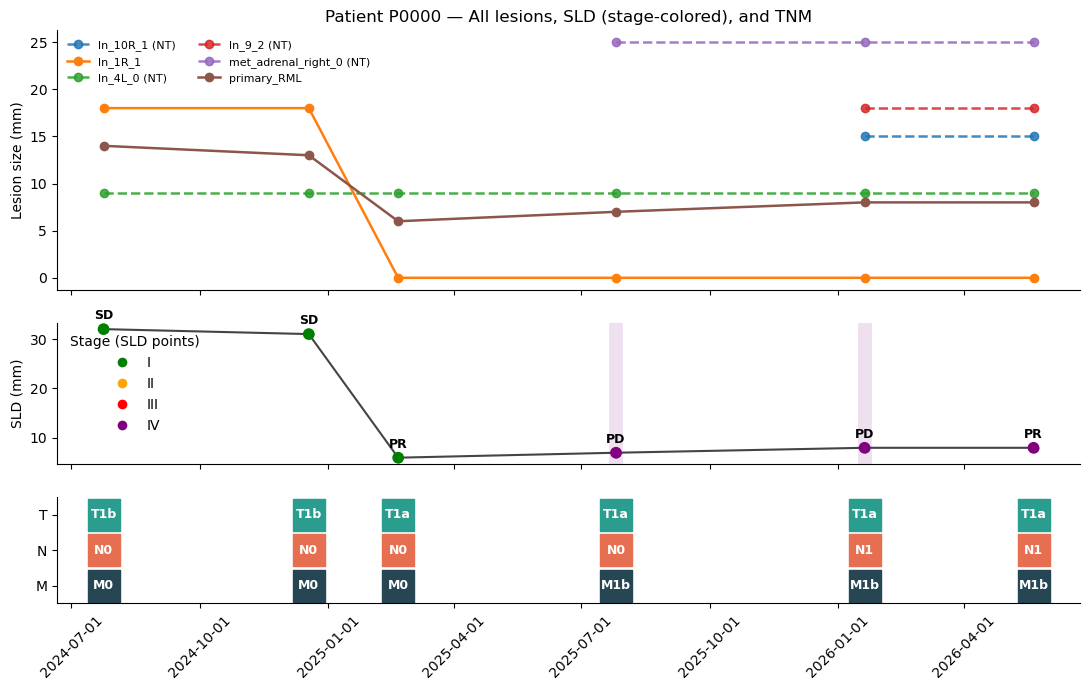

In [27]:
# 1) Build per_patient from your cases
from collections import defaultdict
per_patient = defaultdict(list)
for case, dt in zip(all_cases, all_dates):
    per_patient[case.meta.patient_id].append((dt, case))

# 2) Build JSONL records (RECIST 1.1–style)
jsonl_records = gen.case_to_recist_jsonl(all_cases, all_dates)

# 3) Plot any patient
pid = sorted(per_patient.keys())[0]
plot_patient_course(pid, per_patient, jsonl_records)

# (Optional) loop all patients
# for pid in sorted(per_patient.keys()):
#     plot_patient_course(pid, per_patient, jsonl_records)

In [30]:
# Cell: side-by-side report (.txt) and config (.json) for one patient

from pathlib import Path
import json, html
from IPython.display import display, HTML

# choose the same patient you plotted
pid = pid  # reuse from earlier; or set explicitly, e.g. pid = "P0003"

# point to your output folder used by the generator
root = Path(OUT_DIR)  # e.g. Path("/Users/eri/synthetic_reports/notebooks/out_synthrad")

# locate studies for this patient and sort by visit number (study_01, study_02, …)
studies = sorted((root / pid).glob("study_*"), key=lambda p: int(p.name.split("_")[1]))
if not studies:
    raise FileNotFoundError(f"No studies found under {root / pid}")

cards = []
for i, sd in enumerate(studies, start=1):
    txt_path = next(sd.glob("*.txt"), None)
    json_path = next(sd.glob("*.json"), None)
    if not txt_path or not json_path:
        continue

    report_txt = txt_path.read_text(encoding="utf-8")
    cfg = json.loads(json_path.read_text(encoding="utf-8"))
    cfg_str = json.dumps(cfg, indent=2)

    acc = txt_path.stem
    title_html = f"Study {i} — <span style='color:#000;font-weight:bold'>{html.escape(acc)}</span>"

    cards.append(f"""
      <div class="card">
        <div class="card-title">{title_html}</div>
        <div class="cols">
          <div class="col">
            <div class="col-title">Report (.txt)</div>
            <pre>{html.escape(report_txt)}</pre>
          </div>
          <div class="col">
            <div class="col-title">Config (.json)</div>
            <pre>{html.escape(cfg_str)}</pre>
          </div>
        </div>
      </div>
    """)

css = """
<style>
.card {border:1px solid #ddd; border-radius:8px; margin:14px 0; padding:10px; background:white;}
.card-title {font-weight:600; margin-bottom:8px;}
.cols {display:flex; gap:12px;}
.col {flex:1 1 50%; min-width:0;}
.col-title {font-size:12px; color:#666; margin-bottom:6px;}
pre {
  background:#f9f9f9;
  border:1px solid #ccc;
  border-radius:6px;
  padding:10px;
  max-height:360px;
  overflow:auto;
  margin:0;
  color:#111;         /* <-- force dark text */
  font-size:13px;
  line-height:1.4em;
}
</style>
"""
display(HTML(css + "\n".join(cards)))